In [2]:
mydir = lambda ob: [a for a in dir(ob) if a[0]!='_' and not callable(getattr(ob,a))]
mydircall = lambda ob: [a for a in dir(ob) if a[0]!='_' and callable(getattr(ob,a))]

# Load and prepare data 

In [1]:
import scipy.io
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# mat = scipy.io.loadmat('/content/gdrive/MyDrive/Colab Notebooks/SSM_Work_Space/Data/RawData8Port.mat')  
mat = scipy.io.loadmat('/Users/yashar/Google-Drive/Colab Notebooks/SSM_Work_Space/Data/RawData8Port.mat')  

data_df = pd.DataFrame(mat['datas'][0]);

# get rid of redundant 0-indices in mat['datas'] and mat['ports'] and flatten inner-most np-arrays:
ports_all_animals = [[[X_ani_ses.flatten()[0]] if X_ani_ses.size else [] for  X_ani_ses in X_ani[0]] for X_ani in list(mat['ports'][0])]
datas_all_animals = [[[np.array(X_ani_ses_trl.flatten(), dtype=np.float64) for X_ani_ses_trl in X_ani_ses[0]] for  X_ani_ses in X_ani[0]] for X_ani in list(mat['datas'][0])]
# get average poke angle (for the simple model):
datas_all_animals_avgpoke = [[np.array([np.angle(np.exp(1j * X_ani_ses_trl).mean()) if X_ani_ses_trl.size else np.nan for X_ani_ses_trl in X_ani_ses]) for  X_ani_ses in X_ani] for X_ani in datas_all_animals]

# Define models

In [67]:
import numpy.random as npr
import ssm
import ssm.observations as obs
import ssm.hierarchical as hier
import ssm.stats as stats
from ssm.observations import VonMisesObservations, Observations
from ssm.hmm import HMM
from ssm.util import ensure_args_are_lists, one_hot

# a new VonMises class with fixed mu's (means) and with (approximately) 0 kappa (VM precision) for the 0-th HMM state (k=0 below)
class VonMisesObservationsPablo(VonMisesObservations):
    def __init__(self, K, D, M=0):
        super(VonMisesObservations, self).__init__(K, D, M)
        # self.mus = npr.randn(K, D)
        self.log_kappas = np.log(-1*npr.uniform(low=-1, high=0, size=(K, D)))

    @property
    def params(self):
        # return self.mus, self.log_kappas
        self.log_kappas

    @params.setter
    def params(self, value):
        # self.mus, self.log_kappas = value
        self.log_kappas = value

    def permute(self, perm):
        # self.mus = self.mus[perm]
        self.log_kappas = self.log_kappas[perm]

    def log_likelihoods(self, data, input, mask, tag):
        # mus, kappas = self.mus, np.exp(self.log_kappas)
        mus, kappas = input, np.exp(self.log_kappas)

        mask = np.ones_like(data, dtype=bool) if mask is None else mask
        # print(f"data = {data.shape}, mus = {mus.shape}, kappas = {kappas.shape}, mask = {mask.shape}")
        return stats.vonmises_logpdf(data[:, None, :], mus, kappas, mask=mask[:, None, :])

    def sample_x(self, z, xhist, input=None, tag=None, with_noise=True):
        # D, mus, kappas = self.D, self.mus, np.exp(self.log_kappas)
        D, mus, kappas = self.D, input, np.exp(self.log_kappas)
        return npr.vonmises(self.mus[z], kappas[z], D)

    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):

        x = np.concatenate(datas) # T x D
        weights = np.concatenate([Ez for Ez, _, _ in expectations])  # T x K
        assert x.shape[0] == weights.shape[0]

        # convert angles to 2D representation and employ closed form solutions
        x_k = np.stack((np.sin(x), np.cos(x)), axis=1)  # T x 2 x D

        r_k = np.tensordot(weights.T, x_k, axes=1)  # K x 2 x D
        r_norm = np.sqrt(np.sum(np.power(r_k, 2), axis=1))  # K x D
        # r_norm = np.atleast_2d(r_norm).T # added by Yashar to avoid error for D==1

        # mus_k = np.divide(r_k, r_norm[:, None])  # K x 2 x D
        r_bar = np.divide(r_norm, np.sum(weights, 0)[:, None])  # K x D

        # print(f"Ez = {expectations[0][0].shape}, r_norm = {r_norm.shape}, x = {x.shape}, weights = {weights.shape}, x_k = {x_k.shape}, r_k = {r_k.shape}")
        mask = (r_norm.sum(1) == 0)
        # mus_k[mask] = 0
        r_bar[mask] = 0

        # Approximation
        kappa0 = r_bar * (self.D + 1 - np.power(r_bar, 2)) / (1 - np.power(r_bar, 2))  # K,D

        kappa0[kappa0 == 0] += 1e-6

        #print(f"r_bar = {r_bar.shape}, kappa0 = {kappa0.shape}, self.log_kappas = {self.log_kappas.shape}")
        for k in range(self.K):
            #self.mus[k] = np.arctan2(*mus_k[k])  #
            if k==0:
                self.log_kappas[0] = -20  # K, D
            else:
                self.log_kappas[k] = np.log(kappa0[k])  # K, D
                
    def smooth(self, expectations, data, input, tag):
        # mus = self.mus
        mus = input
        return expectations.dot(mus)        

class PoissonObservations(Observations):

    def log_likelihoods(self, data, input, mask, tag):
        lambdas = np.exp(self.log_lambdas)
        mask = np.ones_like(data, dtype=bool) if mask is None else mask
        return stats.poisson_logpdf(data[:, None, :], lambdas, mask=mask[:, None, :])

    def sample_x(self, z, xhist, input=None, tag=None, with_noise=True):
        lambdas = np.exp(self.log_lambdas)
        return npr.poisson(lambdas[z])

    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        x = np.concatenate(datas)
        weights = np.concatenate([Ez for Ez, _, _ in expectations])
        for k in range(self.K):
            self.log_lambdas[k] = np.log(np.average(x, axis=0, weights=weights[:,k]) + 1e-16)

    def smooth(self, expectations, data, input, tag):
        """
        Compute the mean observation under the posterior distribution
        of latent discrete states.
        """
        return expectations.dot(np.exp(self.log_lambdas))

# a Poisson VonMises observation class with fittable rates, fixed mu's (means) and with (approximately) 0 kappa (VM precision) for the 0-th HMM state (k=0 below)
class PoissonVonMisesObservations(VonMisesObservations):
    def __init__(self, K, D, M=0):
        super(VonMisesObservations, self).__init__(K, D, M)
        self.log_lambdas = np.zeros((K, D))
        self.log_kappas = np.log(-1*npr.uniform(low=-1, high=0, size=(K, D)))

    @property
    def params(self):
        return self.log_lambdas, self.log_kappas

    @params.setter
    def params(self, value):
        self.log_lambdas, self.log_kappas = value

    def permute(self, perm):
        self.log_lambdas = self.log_lambdas[perm]
        self.log_kappas = self.log_kappas[perm]

    def log_likelihoods(self, data, input, mask, tag):
        # mus, kappas = self.mus, np.exp(self.log_kappas)
        mus, kappas = input, np.exp(self.log_kappas)
        lambdas = np.exp(self.log_lambdas)

        mask = np.ones_like(data, dtype=bool) if mask is None else mask
        
        # n_data = np.array([[len(d_o) for d_o in d_t] for d_t in data]) # good for the old format
        n_data = np.array([[np.sum(~np.isnan(d_o)) for d_o in d_t] for d_t in data]) 
        ll_poiss = stats.poisson_logpdf(n_data[:, None, :], lambdas) #, mask=mask[:, None, :])
        if data.shape[-1] == 1: # D == 1
            data = np.stack(data.flatten()) # shape = (T, nmax)
            data = np.nan_to_num(data)
            mask = np.stack(mask.flatten()) # shape = (T, nmax)
            nmax = data.shape[-1] # maximum number of pokes across trials
            ll_vm = stats.vonmises_logpdf(data[:, None, :], np.tile(mus, nmax), np.tile(kappas, nmax), mask=mask[:, None, :]) 
        else:
            raise NotImplementedError

        return ll_poiss + ll_vm

    def sample_x(self, z, xhist, input=None, tag=None, with_noise=True):
        D, mus, kappas = self.D, input, np.exp(self.log_kappas)
        lambdas = np.exp(self.log_lambdas)
        n_pokes = npr.poisson(lambdas[z])
        return np.array([npr.vonmises(self.mus[z], kappas[z], D) for i in range(n_pokes)])

    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        x = np.concatenate(datas) # T x D
        weights = np.concatenate([Ez for Ez, _, _ in expectations])  # T x K
        assert x.shape[0] == weights.shape[0]

        ns = np.array([[np.sum(~np.isnan(d_o)) for d_o in d_t] for d_t in x]) # T x D
        for k in range(self.K):
            self.log_lambdas[k] = np.log(np.average(ns, axis=0, weights=weights[:,k]) + 1e-16)

        if x.shape[-1] == 1: # D == 1
            x = np.stack(x.flatten()) # T x nmax
            m = np.concatenate(masks) # T x D
            m = np.stack(m.flatten()) # T x nmax
            ws = np.tile(weights.T[..., None], m.shape[-1]) # K x T x nmax
            weights = ws[np.tile(m, (ws.shape[0],1,1))].reshape((ws.shape[0],-1)) # K x T1
            weights = weights.T # T1 x K
            x = x[m] # (T1,) where T1 is the total number of non-nan elements in x
            x = x[:,None] # (T1, 1)
        else:
            raise NotImplementedError
        # henceforth D1 == 1 

        # convert angles to 2D representation and employ closed form solutions
        x_k = np.stack((np.sin(x), np.cos(x)), axis=1)  # T1 x 2 x D1

        r_k = np.tensordot(weights.T, x_k, axes=1)  # K x 2 x D1
        r_norm = np.sqrt(np.sum(np.power(r_k, 2), axis=1))  # K x D1
        # r_norm = np.atleast_2d(r_norm).T # added by Yashar to avoid error for D1 == 1

        # mus_k = np.divide(r_k, r_norm[:, None])  # K x 2 x D1
        r_bar = np.divide(r_norm, np.sum(weights, 0)[:, None])  # K x D1

        mask = (r_norm.sum(1) == 0)
        # mus_k[mask] = 0
        r_bar[mask] = 0

        # Approximation
        kappa0 = r_bar * (self.D + 1 - np.power(r_bar, 2)) / (1 - np.power(r_bar, 2))  # K, D1

        kappa0[kappa0 == 0] += 1e-6

        for k in range(self.K):
            #self.mus[k] = np.arctan2(*mus_k[k])  #
            if k==0:
                self.log_kappas[0] = -20  # K, D
            else:
                self.log_kappas[k] = np.log(kappa0[k])  # K, D
                
    def smooth(self, expectations, data, input, tag):
        # TODO: didn't really think much about this... but makes sense(?)
        mus = input
        return expectations.dot(mus)        


class HMMPablo(HMM):
    """
    Base class for hidden Markov models.
    Notation:
    K: number of discrete latent states
    D: dimensionality of observations
    M: dimensionality of inputs
    In the code we will sometimes refer to the discrete
    latent state sequence as z and the data as x.
    """
    def __init__(self, K, D, M=0, init_state_distn=None,
                 transitions='standard',
                 transition_kwargs=None,
                 hierarchical_transition_tags=None,
                 observations="gaussian", observation_kwargs=None,
                 hierarchical_observation_tags=None, **kwargs):
      
        super(HMMPablo, self).__init__(K, D, M=M, init_state_distn=init_state_distn,
                 transitions=transitions,
                 transition_kwargs=transition_kwargs,
                 hierarchical_transition_tags=hierarchical_transition_tags,
                 observations="gaussian", observation_kwargs=observation_kwargs,
                 hierarchical_observation_tags=hierarchical_observation_tags, **kwargs)

        # This is the master list of observation classes.
        # When you create a new observation class, add it here.
        observation_classes = dict(
            gaussian=obs.GaussianObservations,
            diagonal_gaussian=obs.DiagonalGaussianObservations,
            studentst=obs.MultivariateStudentsTObservations,
            t=obs.MultivariateStudentsTObservations,
            diagonal_t=obs.StudentsTObservations,
            diagonal_studentst=obs.StudentsTObservations,
            exponential=obs.ExponentialObservations,
            bernoulli=obs.BernoulliObservations,
            categorical=obs.CategoricalObservations,
            input_driven_obs=obs.InputDrivenObservations,
            poisson=obs.PoissonObservations,
            vonmises=obs.VonMisesObservations,
            vonmisespablo=VonMisesObservationsPablo,
            poissonvonmises=PoissonVonMisesObservations,
            ar=obs.AutoRegressiveObservations,
            autoregressive=obs.AutoRegressiveObservations,
            no_input_ar=obs.AutoRegressiveObservationsNoInput,
            diagonal_ar=obs.AutoRegressiveDiagonalNoiseObservations,
            diagonal_autoregressive=obs.AutoRegressiveDiagonalNoiseObservations,
            independent_ar=obs.IndependentAutoRegressiveObservations,
            robust_ar=obs.RobustAutoRegressiveObservations,
            no_input_robust_ar=obs.RobustAutoRegressiveObservationsNoInput,
            robust_autoregressive=obs.RobustAutoRegressiveObservations,
            diagonal_robust_ar=obs.RobustAutoRegressiveDiagonalNoiseObservations,
            diagonal_robust_autoregressive=obs.RobustAutoRegressiveDiagonalNoiseObservations,
            )

        if isinstance(observations, str):
            observations = observations.lower()
            if observations not in observation_classes:
                raise Exception("Invalid observation model: {}. Must be one of {}".
                    format(observations, list(observation_classes.keys())))

            observation_kwargs = observation_kwargs or {}
            observations = \
                hier.HierarchicalObservations(observation_classes[observations], K, D, M=M,
                                        tags=hierarchical_observation_tags,
                                        **observation_kwargs) \
                if hierarchical_observation_tags is not None \
                else observation_classes[observations](K, D, M=M, **observation_kwargs)
        if not isinstance(observations, obs.Observations):
            raise TypeError("'observations' must be a subclass of"
                            " ssm.observations.Observations")

        self.observations = observations

# Fit the single poke model

In [5]:
# This is all done for the case where we ignore multiple pokes in each trial -- at least the code here doesn't know about it
npr.seed(0)

animal = 0

K = 3 # in this HMM states will be ordered according to: today, yesterday, exploration.
D = 1 # observations are angles (in radians) of the port where the animal poked in each trial.

# you need to construct "datas" which is a list of arrays, one list-element per experimental session, and then the list-element (which is a numpy array) is the sequence of angles (in radians) where the animal poked in that trial.
datas = datas_all_animals_avgpoke[animal]
datas = [np.nan_to_num(d[:,None], nan=100) for d in datas if len(d) > 0]

# you need to also consruct a list "ports", whose elements are the angles (in radians) of reward ports in each session:
ports = ports_all_animals[animal]
ports = [p[0] for p in ports if len(p) > 0]

# mask trials in which mouse didn't poke (i.e. treat them as not observed) 
masks = [~np.isnan(d) for d in datas]

yesterday_port_of_1st_session = 0 # set the "yesterday" port of the 1st session -- which I have arbitrarily set to 0
ports.insert(0, yesterday_port_of_1st_session) 
inputs = [ np.array([0, ports[sess-1], ports[sess]])[:,None] for sess in range(1, len(ports))] # "inputs" will tell the fitting code what the Von Mises means of the 3 markov states (exploration, yeserday's, today's), are in each session:
                                                                                       # they are set equal to 0, yesterday's port, and today's port, respectively. (The choice of 0 for mean of the "exploration" state is arbitrary and doesn't matter, because given that its Von Mises has zero precision, it's going to be flat across the circle, no matter what the mean is) 
test_hmm = HMMPablo(K, D, observations="vonmisespablo")

ll = test_hmm.fit(datas, inputs=inputs, masks=masks)
# and do the rest as before

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
zhat = test_hmm.most_likely_states(mat)

# Fit full model (Poisson-VonMises)

In [6]:
def appfunc(func, d):
    d1 = d.copy()
    for i, pks in enumerate(d):
        d1[i] = func(pks)
    return d1
def addnans(d, n_max):
    func = lambda pks: np.hstack((pks, np.full((n_max - len(pks),), np.nan)))
    return appfunc(func, d)
def get_mask(d):
    return appfunc(lambda pks: ~np.isnan(pks), d)

In [65]:
# This is all done for the case where we ignore multiple pokes in each trial -- at least the code here doesn't know about it
npr.seed(0)

animal = 0

K = 3 # in this HMM states will be ordered according to: today, yesterday, exploration.
D = 1 # observations are angles (in radians) of the port where the animal poked in each trial.

# you need to construct "datas" which is a list of arrays, one list-element per experimental session, and then the list-element (which is a numpy array) is the sequence of angles (in radians) where the animal poked in that trial.
# WARNING: the np.array(d, dtype=object) in next line would work as desired only if the elements of d (which are np.ndarray's) do not have the same length.
datas = [np.array(d, dtype=object) for d in datas_all_animals[animal] if len(d) > 0] # datas[i].shape = (T_i,)
n_max = np.concatenate([np.array([len(d_t) for d_t in d]) for d in datas]).max()
# add trailing nan's so the poke-sequence has equal length across trials:
datas = [addnans(d, n_max) for d in datas] # datas[i].shape = (T_i,)
masks = [get_mask(d) for d in datas] # masks[i].shape = (T_i,)
datas = [d[:,None] for d in datas] # datas[i].shape = (T_i, 1)
masks = [m[:,None] for m in masks] # masks[i].shape = (T_i, 1)

# you need to also consruct a list "ports", whose elements are the angles (in radians) of reward ports in each session:
ports = ports_all_animals[animal]
ports = [p[0] for p in ports if len(p) > 0]

yesterday_port_of_1st_session = 0 # set the "yesterday" port of the 1st session -- which I have arbitrarily set to 0
ports.insert(0, yesterday_port_of_1st_session) 
inputs = [ np.array([0, ports[sess-1], ports[sess]])[:,None] for sess in range(1, len(ports))] # "inputs" will tell the fitting code what the Von Mises means of the 3 markov states (exploration, yeserday's, today's), are in each session:
                                                                                       # they are set equal to 0, yesterday's port, and today's port, respectively. (The choice of 0 for mean of the "exploration" state is arbitrary and doesn't matter, because given that its Von Mises has zero precision, it's going to be flat across the circle, no matter what the mean is) 
CTRL = False
randport = lambda _: np.random.randint(-3,4) * np.pi / 4
inputs_ctrl = [ np.array([0, randport(1), ports[sess]])[:,None] for sess in range(1, len(ports))] # "inputs" will tell the fitting code what the Von Mises means of the 3 markov states (exploration, yeserday's, today's), are in each session:
    
model = HMMPablo(K, D, observations="poissonvonmises")

if CTRL: 
    ll = model.fit(datas, inputs=inputs_ctrl, masks=masks)
else:
    ll = model.fit(datas, inputs=inputs, masks=masks)
# and do the rest as before

  0%|          | 0/100 [00:00<?, ?it/s]

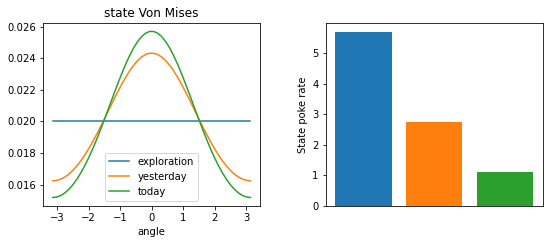

In [66]:
lambdas = np.exp(model.observations.params[0].flatten())
kappas  = np.exp(model.observations.params[1])
labels = ["exploration", "yesterday", "today"]

thetas = np.linspace(-np.pi,np.pi, 50)
von_mis = lambda th, k: np.exp(k * np.cos(th)) / np.sum(np.exp(k * np.cos(th)))
fig, axs = plt.subplots(1,2, figsize=np.array([6.4*2, 4.8]) * .7)
fig.subplots_adjust(wspace=.3)
ax = axs[0]
for k, lb in zip(kappas, labels):
    ax.plot(thetas, von_mis(thetas, k), label=lb)
ax.set_xlabel("angle")
ax.set_title("state Von Mises")
ax.legend();

ax = axs[1]
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(len(lambdas))]
ax.bar(np.arange(len(lambdas)), lambdas, color=colors)
ax.set_ylabel("State poke rate")
ax.set_xticks([]); # 0,1,2]);

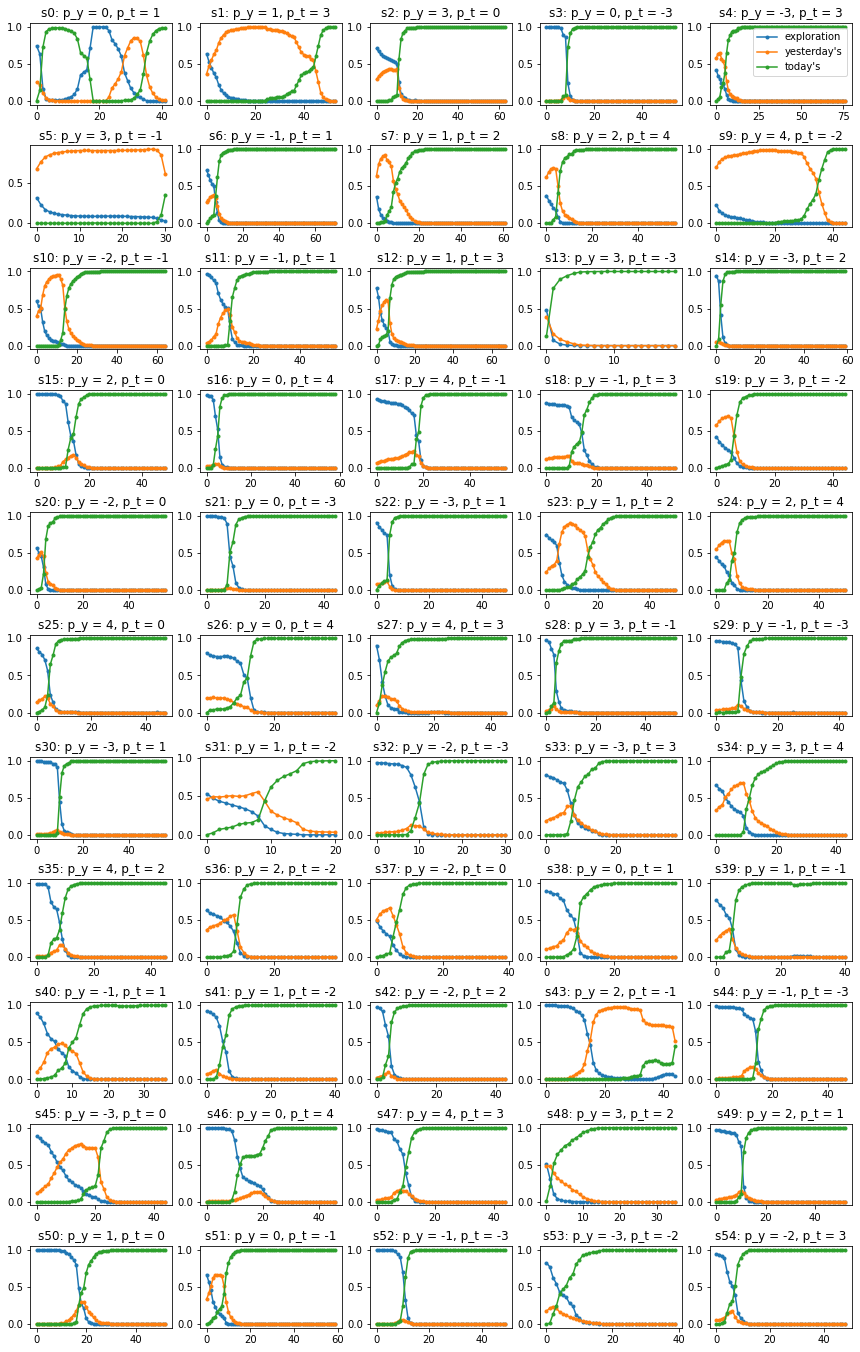

In [33]:
n_ses = len(datas)
ncol = 5
nrow = int(np.ceil(n_ses / ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=np.array([6.4*2.3, 4.8*5]))
fig.subplots_adjust(hspace=.5)
for ses in range(n_ses):
    ax = axs[ses//ncol, ses%ncol]
    Ez, _, _ = model.expected_states(datas[ses], inputs[ses], masks[ses])
    ax.plot(np.arange(Ez.shape[0]), Ez, '.-');
    prts = np.array(inputs[ses][1:].flatten()*8/2/np.pi, dtype=int)
    ax.set_title(f"s{ses}: p_y = {prts[0]}, p_t = {prts[1]}")
    
    if ses == ncol-1:
        ax.legend(["exploration", "yesterday's", "today's"])
    # ax.set_xlabel("trials")

<ipython-input-99-3061ff6290f2>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 1, figsize=np.array([6.4, 4.8*2])*.6)


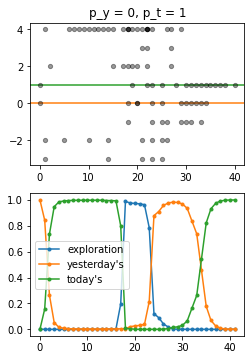

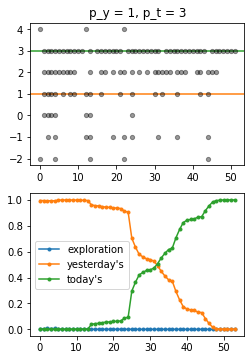

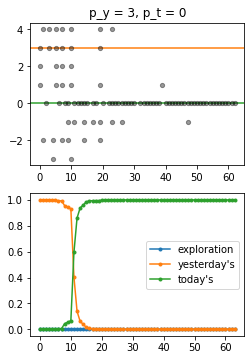

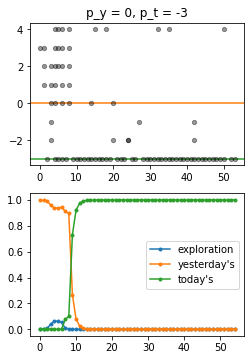

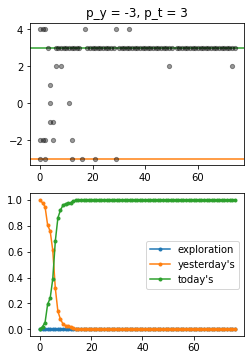

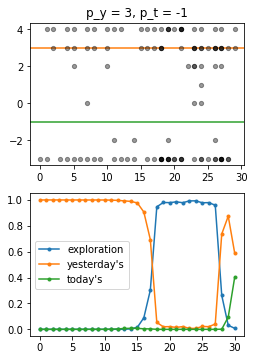

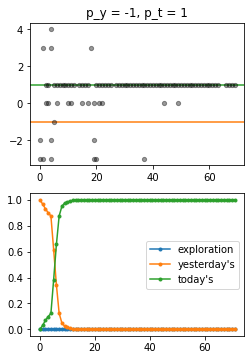

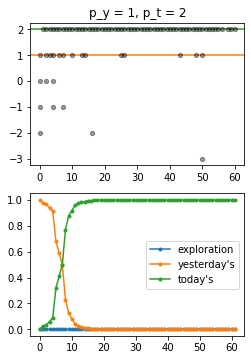

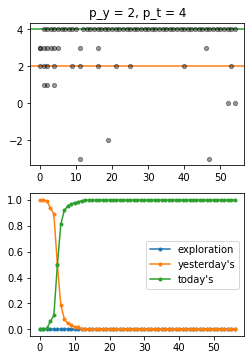

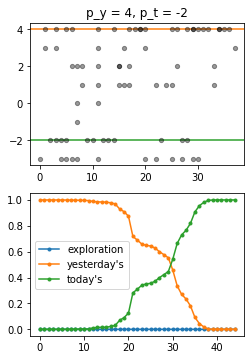

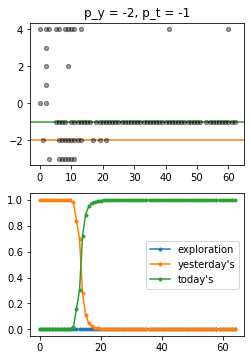

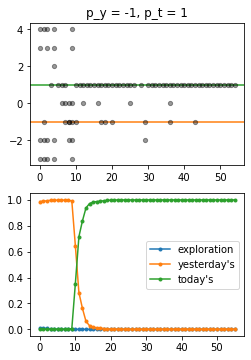

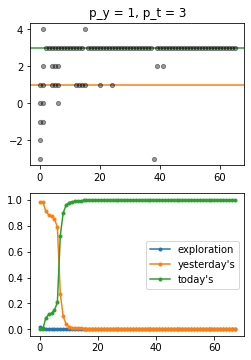

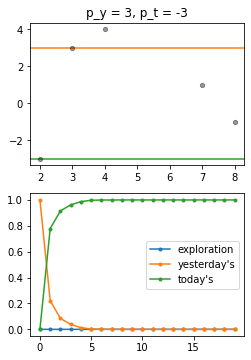

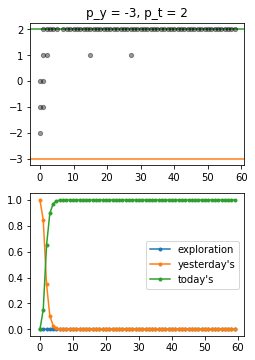

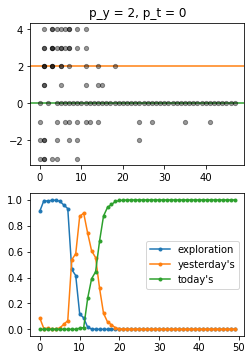

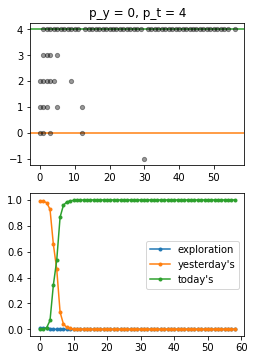

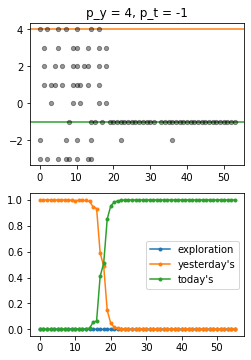

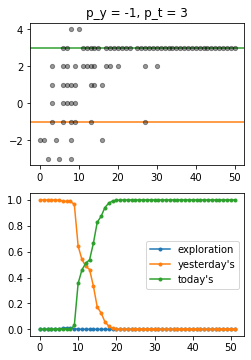

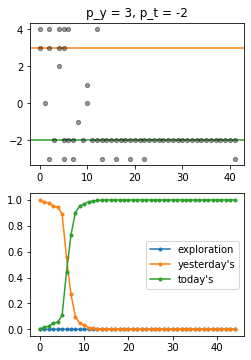

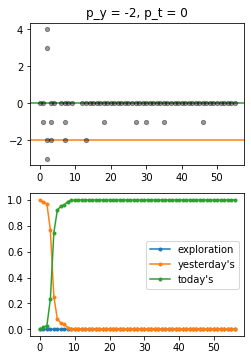

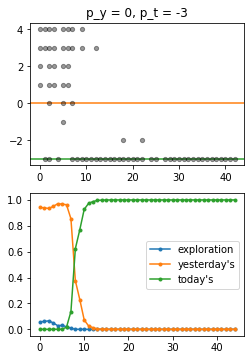

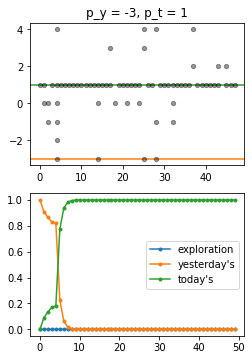

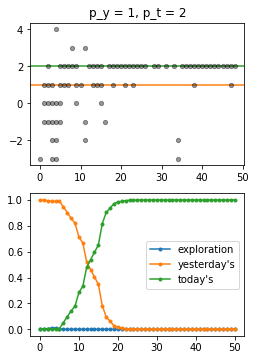

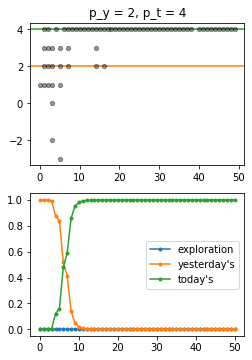

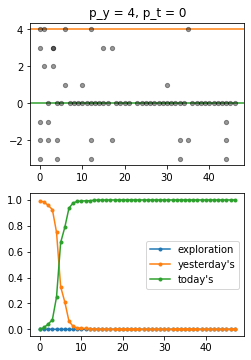

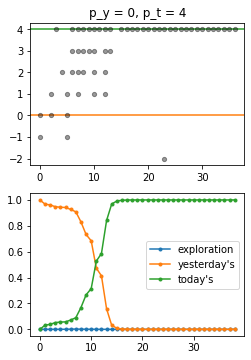

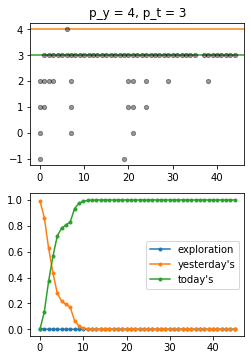

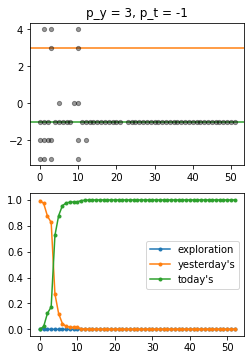

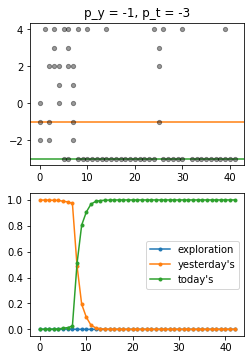

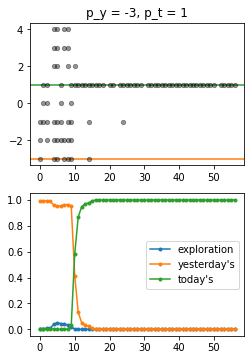

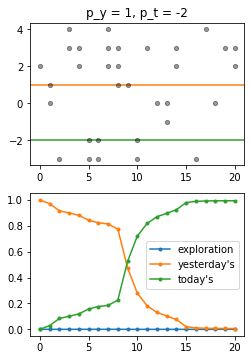

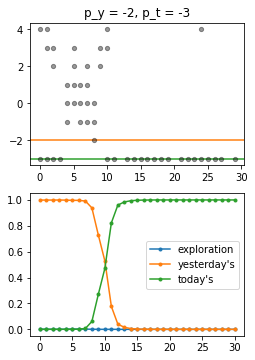

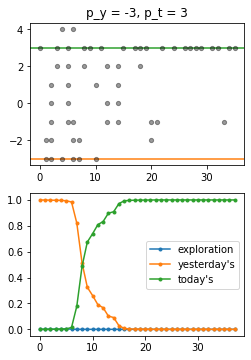

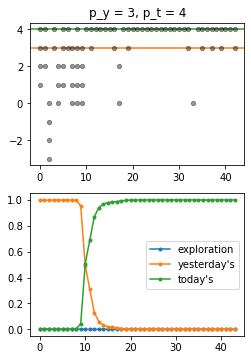

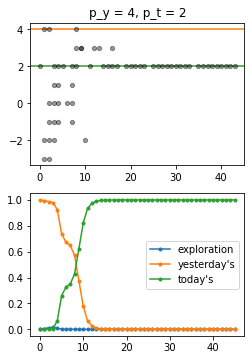

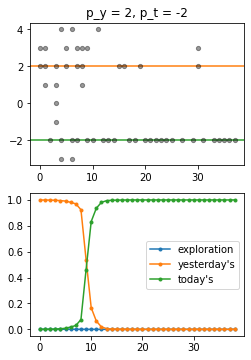

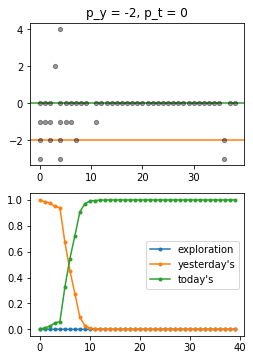

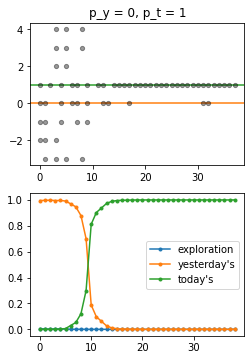

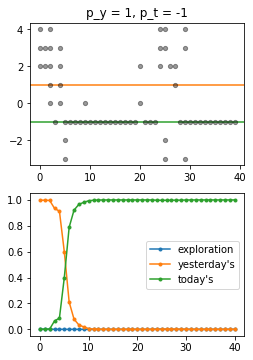

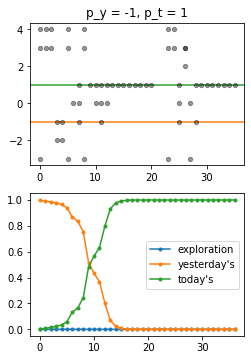

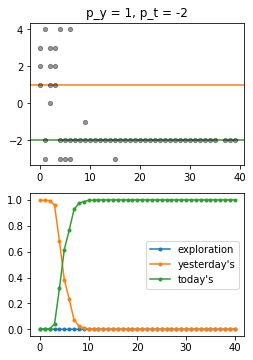

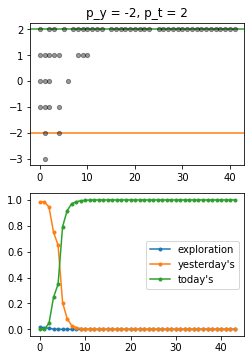

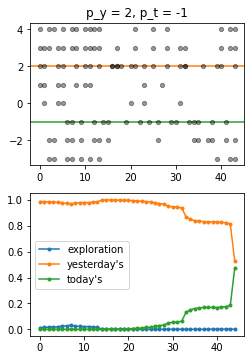

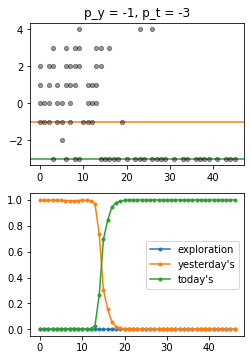

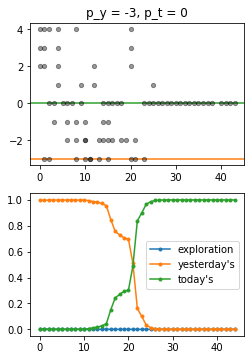

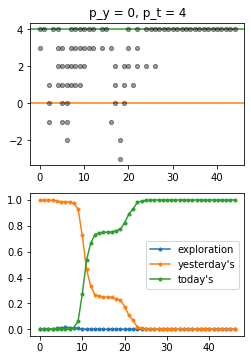

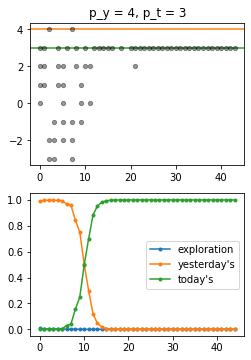

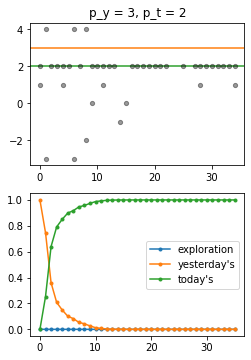

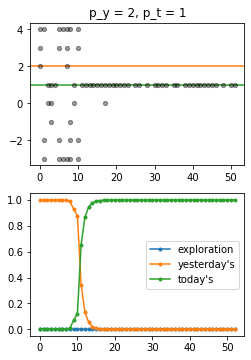

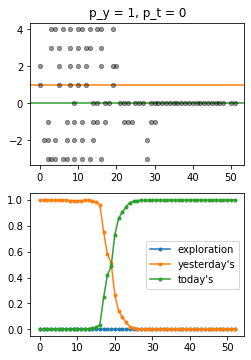

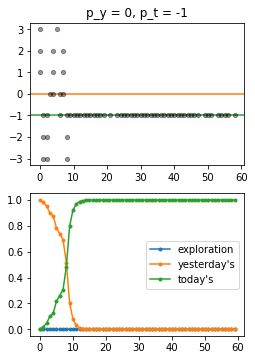

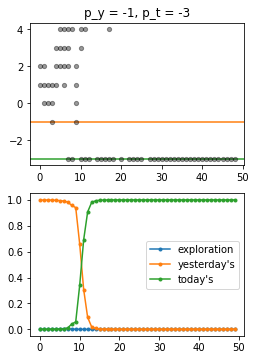

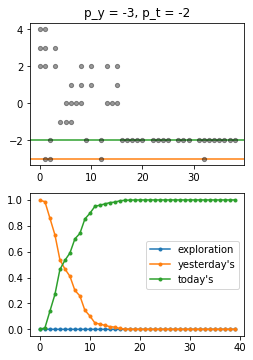

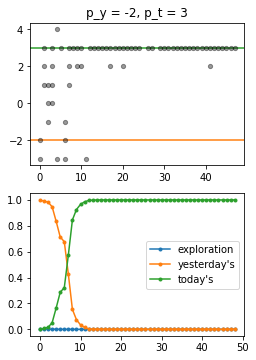

In [99]:




















































for ses in range(len(datas)):

    fig, axs = plt.subplots(2, 1, figsize=np.array([6.4, 4.8*2])*.6)
    #fig.subplots_adjust(hspace=.5)

    prts = np.array(inputs[ses][1:].flatten()*8/2/np.pi, dtype=int)
    poks = [d[~np.isnan(d)] for d in datas[ses].flatten()]
    trials = np.hstack([i + 0*d for i, d in enumerate(poks)])
    poks = np.hstack(poks)*8/2/np.pi #, dtype=int

    ax = axs[1]
    Ez, _, _ = model.expected_states(datas[ses], inputs[ses], masks[ses])
    ax.plot(np.arange(Ez.shape[0]), Ez, '.-');
    ax.legend(["exploration", "yesterday's", "today's"])

    ms = 8.5
    ax = axs[0]
    ax.axhline(prts[0], c="tab:orange")
    ax.axhline(prts[1], c="tab:green")
    ax.plot(trials, poks, 'k.', alpha=0.4, ms=ms);
    prts = np.array(inputs[ses][1:].flatten()*8/2/np.pi, dtype=int)
    ax.set_title(f"p_y = {prts[0]}, p_t = {prts[1]}")

In [46]:
λs = np.exp(model.observations.params[0])
κs = np.exp(model.observations.params[1])
λs, κs

(array([[5.69416121],
        [2.73075066],
        [1.09890675]]),
 array([[2.06115362e-09],
        [2.01999878e-01],
        [2.63348583e-01]]))

# Checking whether poke counts are really Poisson 

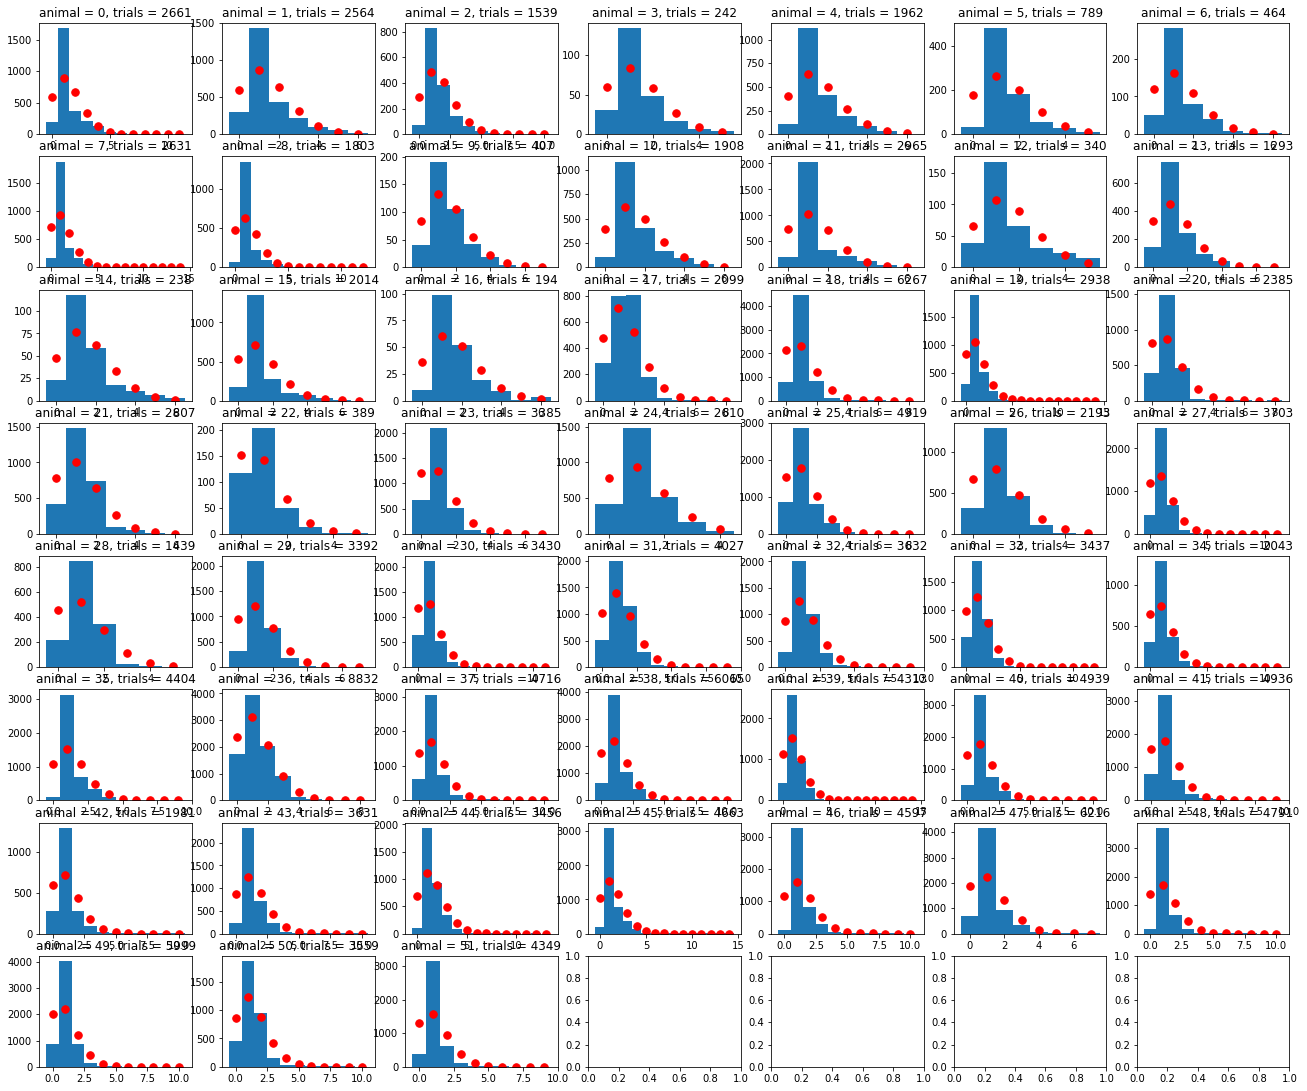

In [ ]:
mylen = lambda d_s: np.array([[len(d_o) for d_o in d] for d in d_s])
import matplotlib.pyplot as plt
nsub = len(datas_all_animals)
ncols = 7
nrows = 1 + nsub // ncols
fig, axs = plt.subplots(nrows, ncols, figsize=np.array([6.4,4.8*nrows/ncols])*3.5)
for i_a, datasu in enumerate(datas_all_animals):
    ax = axs[i_a // ncols, i_a % ncols]
    datas1 = [np.array(d, dtype=object)[:,None] for d in datasu if len(d) > 0]
    n_datas = np.concatenate([mylen(d) for d in datas1])

    ax.set_title(f"animal = {i_a}, trials = {n_datas.shape[0]}") #", max(n) = {n_datas.max()}")
    n_v = np.arange(n_datas.max())
    n_v_fac = np.array([np.math.factorial(n) for n in n_v])

    edges = -0.5 + np.arange(n_datas.max()+1)
    ax.hist(n_datas, edges)

    lam = n_datas.mean() # 1.5
    ax.plot(n_v, len(n_datas) * lam**n_v * np.exp(-lam) / n_v_fac, "r.", ms=15)    
